# Artificial Neural Networks and Deep Learning

---

## Homework 2: Double U-Net


## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
data = np.load("/kaggle/input/clean-dataset/clean_dataset.npz")

X_train = data["images"]
y_train = data["labels"]
X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [3]:
# Splitting the dataset 80/20 (training and validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

#Display the resulting shapes
print(f"Training images shape: {X_train.shape}, Validation images shape: {X_val.shape}")
print(f"Training masks shape: {y_train.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2004, 64, 128), Validation images shape: (501, 64, 128)
Training masks shape: (2004, 64, 128), Validation masks shape: (501, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of classes: {num_classes}")

X_train shape: (2004, 64, 128, 1)
y_train shape: (2004, 64, 128)
X_test shape: (10022, 64, 128, 1)
Number of classes: 5


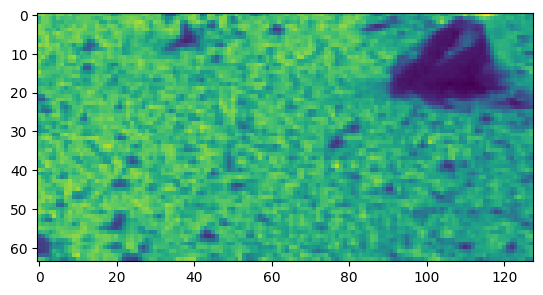

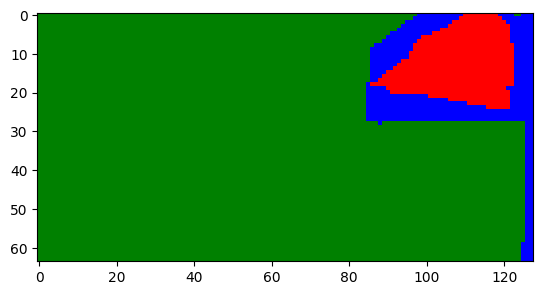

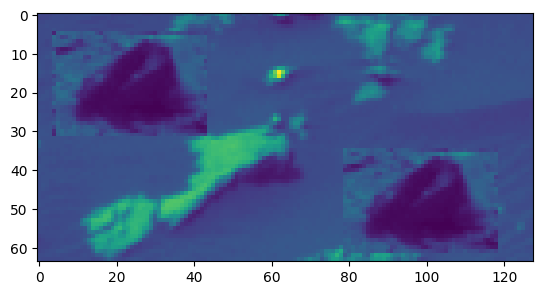

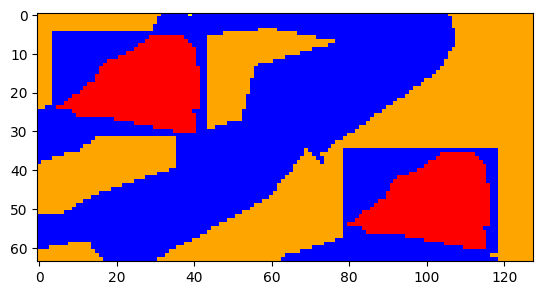

Number of occurrences of each label: 
Label 0.0: 8858727
Label 1.0: 9758991
Label 2.0: 6894995
Label 3.0: 5218906
Label 4.0: 2101917


In [5]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['blue', 'green', 'yellow', 'orange', 'red'])
vmin, vmax = 0, 4

# Show the selected image
i=479
plt.imshow(X_train[i])
plt.show()
plt.imshow(y_train[i], cmap=cmap, vmin=vmin, vmax=vmax)
plt.show()

# Oversampling custom function
def oversampling_big_rock(X,y,alpha=1.0):
    batch_size, height, width, channel = X.shape  # No channel dimension for grayscale
    # Generate CutMix lambda
    lam = np.random.beta(alpha, alpha)
    cut_rat = np.sqrt(1.0 - lam)  # Cutout ratio
    cut_h = int(height * cut_rat)
    cut_w = int(width * cut_rat)
    
    # Choose cutout position
    x1,x2= 85,125
    y1,y2= 0, 26
    shift_x = x2 - x1
    shift_y = y2 - y1
    
    image_cut = X[i, y1:y2, x1:x2]
    mask_cut = y[i, y1:y2, x1:x2]

    # Ensure that there is no other class label
    mask_cut = tf.where(mask_cut == 1, 0, mask_cut)

    # Add a row of zeros to the label since there is no enough background
    last_row_mask = mask_cut[-1:]
    modified_mask = tf.concat([last_row_mask, mask_cut], axis=0)
    shift_y = shift_y + 1

    # Add a row of backgruoud to the image
    last_row_image = image_cut[-1:]
    modified_image = tf.concat([last_row_image, image_cut], axis=0)

    # Apply CutMix
    X_cut = X.copy()
    y_cut = y.copy()
    
    for ind in range(len(X_cut)):
        rx1 = np.random.randint(0, width-shift_x)
        ry1 = np.random.randint(0, height-shift_y)
        rx2 = rx1+shift_x
        ry2 = ry1+shift_y
        X_cut[ind, ry1:ry2, rx1:rx2] = modified_image
        y_cut[ind, ry1:ry2, rx1:rx2] = modified_mask
        
    return X_cut, y_cut

X_cut_r, y_cut_r = oversampling_big_rock(X_train, y_train)
X_cut_r, y_cut_r = oversampling_big_rock(X_cut_r, y_cut_r)

# Show an oversampled image
plt.imshow(X_cut_r[130])
plt.show()
plt.imshow(y_cut_r[130],cmap=cmap, vmin=vmin, vmax=vmax)
plt.show()

# Concatenate the results
X_train = np.concatenate((X_train,X_cut_r),axis=0)
y_train = np.concatenate((y_train,y_cut_r),axis=0)

# Check the number of occurrences of each label
unique, counts = np.unique(y_train, return_counts=True)

print('Number of occurrences of each label: ')
for i in range(unique.size):
    print(f'Label {unique[i]}: {counts[i]}')

In [7]:
import cv2
# Define a custom function for random horizontal/vertical flip
def random_flip (train_img, train_mask, threshold=0.5):
    for i in range(train_img.shape[0]):
        h_or_v = 0 if np.random.uniform(0, 1) < threshold else 1
        train_img[i] = np.expand_dims(cv2.flip(train_img[i].squeeze(), h_or_v), axis=-1)
        train_mask[i] = cv2.flip(train_mask[i].squeeze(), h_or_v)
    return train_img, train_mask

In [8]:
X_train_len = int(X_train.shape[0])

# Perform random horizontal/vertical flip on a copy of the first half of the dataset
X_train_flip = np.array(X_train[:X_train_len], copy = True)
y_train_flip = np.array(y_train[:X_train_len], copy = True)
X_train_copy, y_train_copy = random_flip(X_train_flip, y_train_flip)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_flip], axis=0)
y_train = np.concatenate([y_train, y_train_flip], axis=0)

## 🛠️ Train and Save the Model

In [10]:
# Define hyperparameters
epochs = 200
batch_size = 64

In [11]:
# Define callbacks
# Early stopping to stop the training when val_mean_iou stop to increase
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True,
    start_from_epoch=50
)

# Reduce LR when val_loss stop to decrease to avoid local minumum
reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=20
)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [12]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', dilation_rate=1, stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate, kernel_initializer='he_normal', use_bias=False, name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Add residual pathF
    res = tfkl.Conv2D(filters, kernel_size=1, padding='same', kernel_initializer='he_normal', use_bias=False, name=name + 'conv_res')(input_tensor)
    res = tfkl.Add(name=name + 'add')([res, x])
    #res = tfkl.BatchNormalization(name=name + 'bn_res')(res)
    res = tfkl.Activation(activation, name=name + 'activation_res')(res)
    
    # Return the transformed tensor
    return res

In [13]:
def se_block(input_tensor, filters, name):
    avg_pool = tfkl.GlobalAveragePooling2D(name=name + '_avg_pool')(input_tensor)
    dense1 = tfkl.Dense(filters // 2, activation='relu', name=name + '_dense1')(avg_pool)
    dense2 = tfkl.Dense(filters, activation='sigmoid', name=name + '_dense2')(dense1)
    scale = tfkl.Multiply(name=name + '_scale')([input_tensor, tfkl.Reshape((1, 1, filters))(dense2)])
    return scale

In [14]:
def unet_block_with_se(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # UNet block with integrated attention
    x = unet_block(input_tensor, filters, kernel_size, activation, stack=stack, name=name)
    x = se_block(x, filters, name=name + 'attention')
    return x

In [15]:
def ASPP(input_tensor, filters, name="aspp"):
    shape_input = input_tensor.shape
    
    # 1x1 Convolution
    x1 = tfkl.Conv2D(filters, 1, padding='same', use_bias=False, name=f'{name}_conv_1x1_0')(input_tensor)
    x1 = tfkl.BatchNormalization(name=f'{name}_bn_0')(x1)
    x1 = tfkl.ReLU(name=f'{name}_relu_0')(x1)

    # 3x3 Convolutions with different dilation (atrous) rates
    x2 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=6, kernel_initializer='he_normal', use_bias=False, name=f'{name}_conv_3x3_1')(input_tensor)
    x2 = tfkl.BatchNormalization(name=f'{name}_bn_1')(x2)
    x2 = tfkl.ReLU(name=f'{name}_relu_1')(x2)

    x3 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=12, kernel_initializer='he_normal', use_bias=False, name=f'{name}_conv_3x3_2')(input_tensor)
    x3 = tfkl.BatchNormalization(name=f'{name}_bn_2')(x3)
    x3 = tfkl.ReLU(name=f'{name}_relu_2')(x3)

    x4 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=18, kernel_initializer='he_normal', use_bias=False, name=f'{name}_conv_3x3_3')(input_tensor)
    x4 = tfkl.BatchNormalization(name=f'{name}_bn_3')(x4)
    x4 = tfkl.ReLU(name=f'{name}_relu_3')(x4)

    # Image-level features (Global Average Pooling)
    x5 = tfkl.GlobalAveragePooling2D()(input_tensor)
    x5 = tfkl.Reshape((1, 1, shape_input[-1]))(x5)
    x5 = tfkl.Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal', use_bias=False, name=f'{name}_conv_gap')(x5)
    x5 = tfkl.BatchNormalization(name=f'{name}_bn_gap')(x5)
    x5 = tfkl.ReLU(name=f'{name}_relu_gap')(x5)
    shape_x5 = x5.shape 
    x5 = tfkl.UpSampling2D(size=(shape_input[1] // shape_x5[1], shape_input[2] // shape_x5[2]), interpolation='bilinear')(x5)

    # Concatenate all the features
    x = tfkl.Concatenate(axis=-1)([x1, x2, x3, x4, x5])

    # Final 1x1 Convolution to reduce channels
    x = tfkl.Conv2D(filters, 1, padding='same', kernel_initializer='he_normal', use_bias=False, name=f'{name}_final_conv')(x)
    x = tfkl.BatchNormalization(name=f'{name}_bn_final')(x)
    x = tfkl.ReLU(name=f'{name}_relu_final')(x)

    return x

In [18]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tfk.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [19]:
# Custom losses implementation
# Generalized Dice Loss
def generalized_dice_loss(y_true, y_pred):
    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute per-class weights
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(0, 1, 2))
    weights = 1 / (tf.reduce_sum(y_true, axis=(0, 1, 2)) ** 2 + 1e-6)
    
    # Generalized Dice Score
    dice_score = tf.reduce_sum(weights * numerator) / tf.reduce_sum(weights * denominator)
    
    return 1 - dice_score

# Focal loss
def focal_loss(y_true, y_pred, gamma=2.0):
    focal_loss = -tf.reduce_mean(
       tf.reduce_sum(
           y_true * ((1 - y_pred) ** gamma) * tf.math.log(y_pred), axis=-1
       )
    ) 
    return focal_loss

def combined_loss(y_true, y_pred, num_classes=5, alpha=0.5, beta=0.5, gamma=0):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (label 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Ignore background in ground truth
    y_pred = y_pred[..., 1:]  # Ignore background in predictions

    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)

    # 1. Generalized Dice Loss
    GDL = generalized_dice_loss(y_true_one_hot, y_pred)
    
    # 2. Focal Loss
    FL = focal_loss(y_true_one_hot, y_pred)
    
    # Combine the losses with weights
    total_loss = alpha * GDL + beta * FL
    
    return total_loss

In [20]:
# Define the Double U-Net architecture
def double_unet(input_shape=(64, 128, 1), num_classes=num_classes):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
     
    down_block_4 = unet_block_with_se(d3, 512, name='down_block4_')
    down_block_4 = tfkl.Dropout(0.5)(down_block_4)
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = ASPP(d4, 1024)
    bottleneck = tfkl.Dropout(0.5)(bottleneck)
    
    # Upsampling path
    u4 = tfkl.UpSampling2D(size=(2, 2))(bottleneck)
    u4 = tfkl.Concatenate()([u4, down_block_4])
    u4 = unet_block_with_se(u4, 512, name='up_block4_')
    
    u3 = tfkl.UpSampling2D(size=(2, 2))(u4)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block_with_se(u3, 256, name='up_block3_')
    
    u2 = tfkl.UpSampling2D(size=(2, 2))(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_')

    u1 = tfkl.UpSampling2D(size=(2, 2))(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    mult = tfkl.Multiply()([input_layer, output_layer])

    # Downsampling path
    down_block_1_second = unet_block_with_se(mult, 64, name='down_block1_second_')
    d1_second = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(down_block_1_second)

    down_block_2_second = unet_block_with_se(d1_second, 128, name='down_block2_second_')
    d2_second = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(down_block_2_second)

    down_block_3_second = unet_block_with_se(d2_second, 256, name='down_block3_second_')
    d3_second = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(down_block_3_second)

    down_block_4_second = unet_block_with_se(d3_second, 512, name='down_block4_second_')
    down_block_4_second = tfkl.Dropout(0.5)(down_block_4_second)
    d4_second = tfkl.MaxPooling2D(pool_size=(2, 2), strides=2)(down_block_4_second)

    # Bottleneck
    bottleneck_second = ASPP(d4_second, 1024)
    bottleneck_second = tfkl.Dropout(0.5)(bottleneck_second)
    
    # Upsampling path
    # In the second upsampling part we use skip connection from both the encoders
    u4_second = tfkl.UpSampling2D(size=(2, 2))(bottleneck_second)
    u4_second = tfkl.Concatenate()([u4, u4_second, down_block_4_second])
    u4_second = unet_block(u4_second, 512, name='up_block4_second_')
    
    u3_second = tfkl.UpSampling2D(size=(2, 2))(u4_second)
    u3_second = tfkl.Concatenate()([u3, u3_second, down_block_3_second])
    u3_second = unet_block(u3_second, 256, name='up_block3_second_')
    
    u2_second = tfkl.UpSampling2D(size=(2, 2))(u3_second)
    u2_second = tfkl.Concatenate()([u2, u2_second, down_block_2_second])
    u2_second = unet_block(u2_second, 128, name='up_block2_second_')

    u1_second = tfkl.UpSampling2D(size=(2, 2))(u2_second)
    u1_second = tfkl.Concatenate()([u1, u1_second, down_block_1_second])
    u1_second = unet_block(u1_second, 64, name='up_block1_second_')

    # Output Layer
    output_layer_second = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer_second')(u1)
    out = tfkl.Concatenate()([output_layer, output_layer_second])
    out = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output')(out)
    
    # Create the Double U-Net model
    double_unet_model = tf.keras.Model(inputs=input_layer, outputs=out, name="DoubleUNet")

    return double_unet_model

In [22]:
model = double_unet(input_shape=input_shape, num_classes=num_classes)

# Define the MeanIoU ignoring the background class
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
optimizer = tfk.optimizers.AdamW()

model.compile(
    loss=combined_loss,
    optimizer=optimizer,
    metrics=['accuracy', mean_iou]
)

model.summary(expand_nested=True, show_trainable=True)

Model: "DoubleUNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       576 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,864 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv… │ (None, 64, 128, │        64 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_add   │ (None, 64, 128, │         0 │ down_block1_c… │   -   │
│ (Add)             │ 64)             │           │ down_block1_a… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,728 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,456 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv… │ (None, 32, 64,  │     8,192 │ max_pooling2d… │   Y 

 Total params: 39,512,257 (150.73 MB)

 Trainable params: 39,492,289 (150.65 MB)

 Non-trainable params: 19,968 (78.00 KB)

In [23]:
history = model.fit(
    X_train, 
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_mean_iou = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation MEAN iou: {final_val_mean_iou}%')

# Save the trained model to a file with the timestamp included in the filename
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Epoch 1/200


I0000 00:00:1734113901.497947     539 service.cc:145] XLA service 0x7f711c003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734113901.497995     539 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-12-13 18:18:42.372525: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k3=0} for conv (f32[1024,20736,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,20736,3,3]{3,2,1,0}, f32[512,1024,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-13 18:18:42.873684: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.501358784s
Trying algorithm eng20{k2=2,k3

125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.4147 - loss: 0.6469 - mean_iou: 0.4267

2024-12-13 18:21:24.292925: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=1,k3=0} for conv (f32[2304,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2304,1024,1,1]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-13 18:21:24.437482: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.144665178s
Trying algorithm eng25{k2=1,k3=0} for conv (f32[2304,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2304,1024,1,1]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.4151 - loss: 0.6466 - mean_iou: 0.4274

2024-12-13 18:22:06.206084: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1024,7632,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,7632,3,3]{3,2,1,0}, f32[512,1024,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-13 18:22:07.111503: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.905573936s
Trying algorithm eng0{} for conv (f32[1024,7632,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,7632,3,3]{3,2,1,0}, f32[512,1024,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"

126/126 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.4155 - loss: 0.6463 - mean_iou: 0.4280 - val_accuracy: 0.3687 - val_loss: 0.7485 - val_mean_iou: 0.1961 - learning_rate: 0.0010
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 73s 579ms/step - accuracy: 0.5439 - loss: 0.5239 - mean_iou: 0.6581 - val_accuracy: 0.2462 - val_loss: 0.8055 - val_mean_iou: 0.1067 - learning_rate: 0.0010
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 563ms/step - accuracy: 0.5573 - loss: 0.4642 - mean_iou: 0.6807 - val_accuracy: 0.2681 - val_loss: 0.7335 - val_mean_iou: 0.1404 - learning_rate: 0.0010
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 563ms/step - accuracy: 0.5715 - loss: 0.4159 - mean_iou: 0.7060 - val_accuracy: 0.5770 - val_loss: 0.6229 - val_mean_iou: 0.4608 - learning_rate: 0.0010
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 71s 563ms/step - accuracy: 0.6037 - loss: 0.3630 - mean_iou: 0.7559 - val_accuracy: 0.5442 - val_loss: 0.6126 - val_mean_iou: 0.4359 - learning_rate: 0.0010
Epoch 6/200
126/126 ━━━━

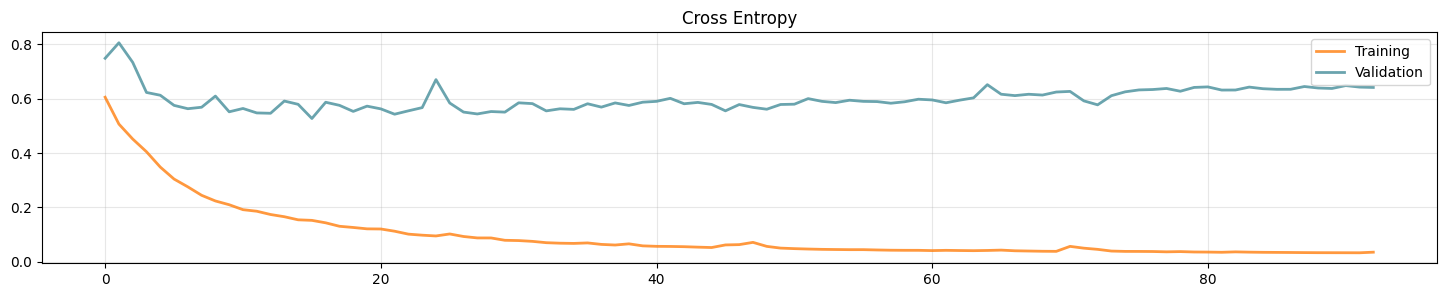

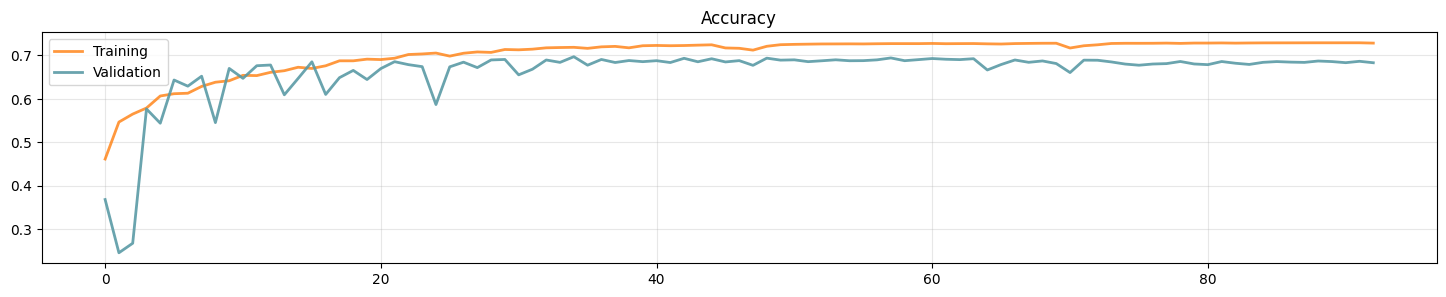

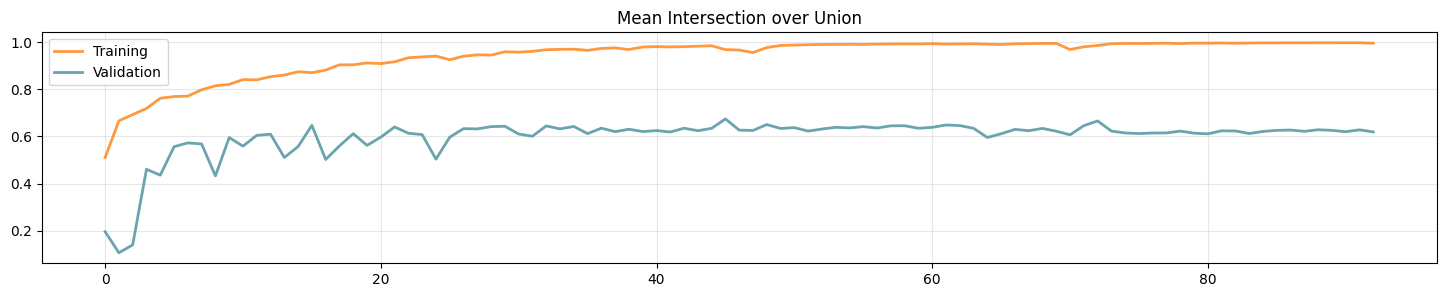

In [24]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [25]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [26]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241213_201118.keras


In [27]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=[combined_loss],
    optimizer=tfk.optimizers.AdamW(),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

predictions = model.predict(X_test)
preds = np.argmax(predictions, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step
Predictions shape: (10022, 64, 128)


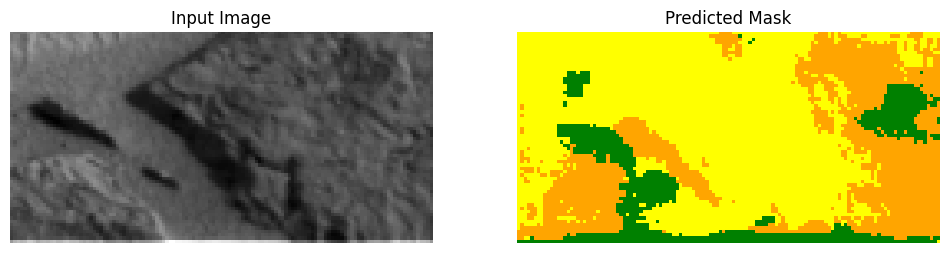

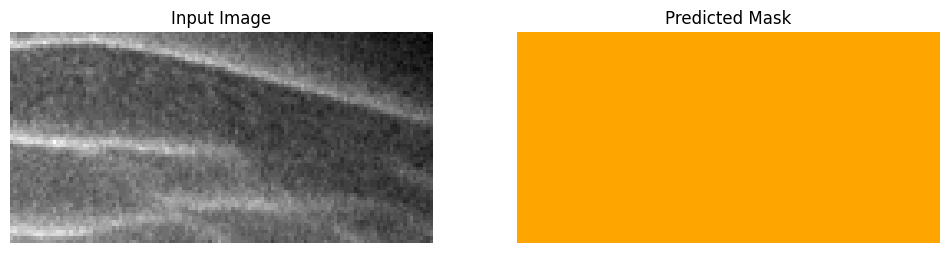

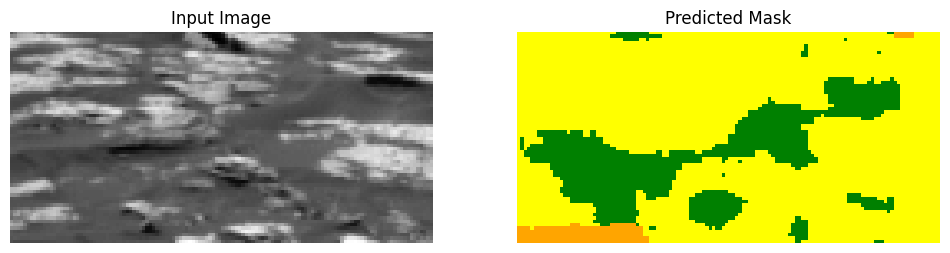

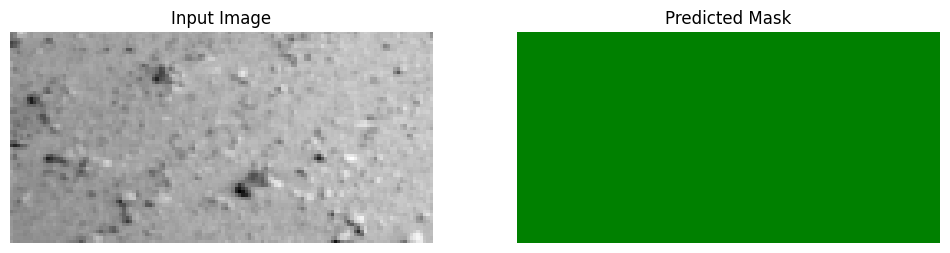

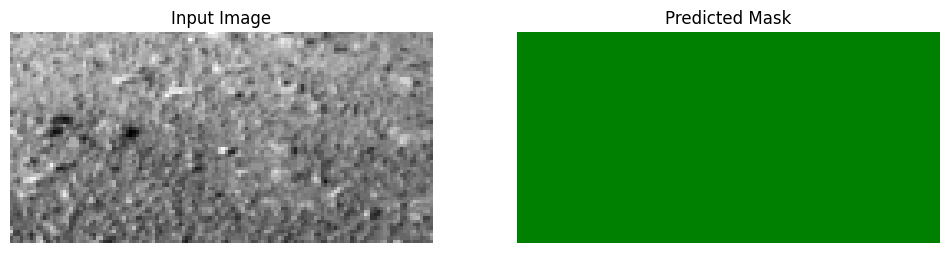

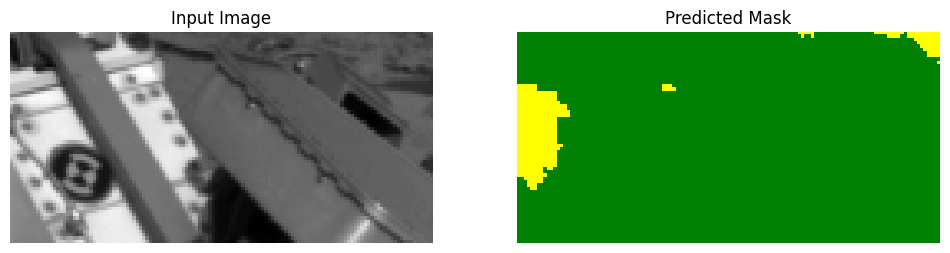

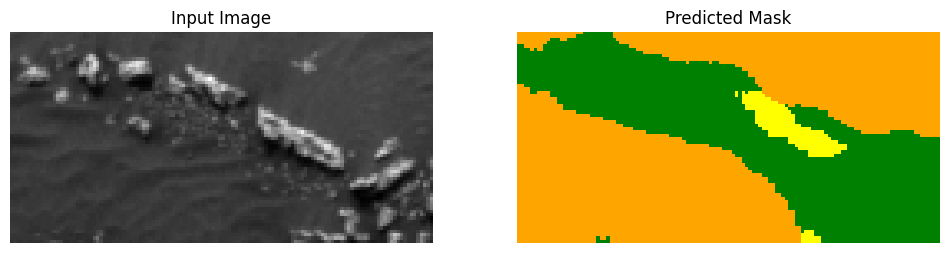

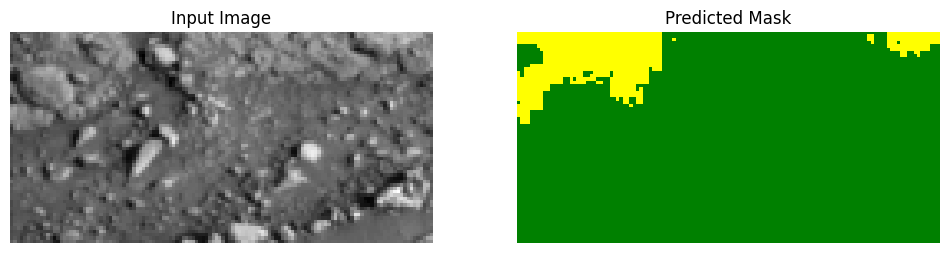

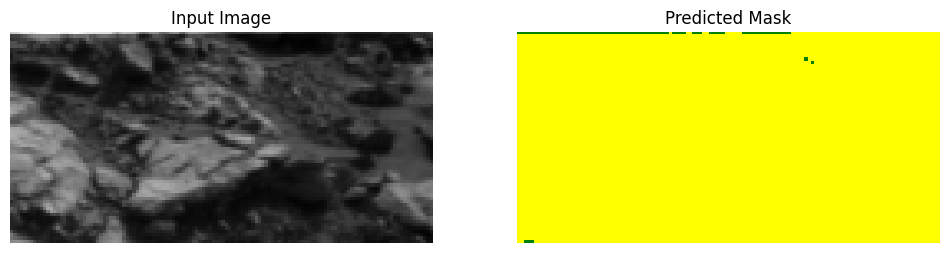

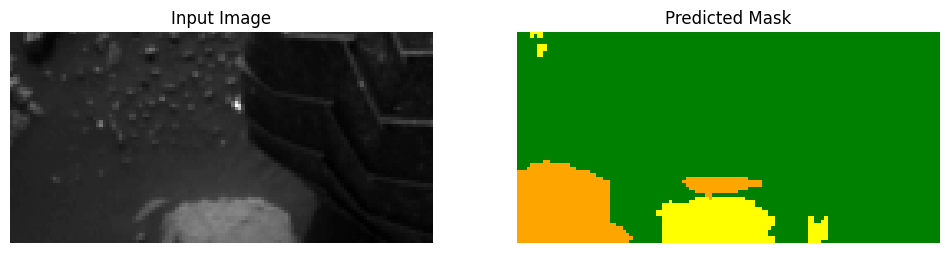

In [28]:
# Show some prediction
num_samples_to_display = 10 
for i in range(num_samples_to_display):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray') 
    plt.title("Input Image")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(preds[i], cmap=cmap, vmin=vmin, vmax=vmax)  # Colorful mask
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)